In [57]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

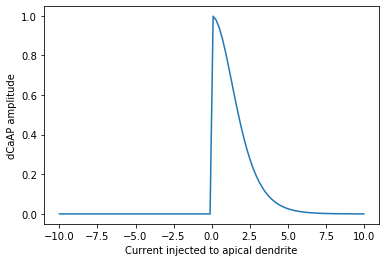

In [58]:
def dCaAP(x, th=0):
    x = x - th
    return 4*torch.sigmoid(x) * (1 - torch.sigmoid(x)) * (x>0).float()

a = torch.linspace(-10,10,100)
b = dCaAP(a, 0)
plt.plot(a,b)
plt.xlabel('Current injected to apical dendrite')
plt.ylabel('dCaAP amplitude')
plt.show()

In [59]:
class Dendritic(nn.Module):
    def __init__(self, in_features, out_features):
        super(Dendritic, self).__init__()
        
        self.apical_synapses   = nn.Parameter(torch.Tensor(out_features, in_features)) #weights
        self.bias              = nn.Parameter(torch.Tensor(out_features)) # bias in weights
        self.apical_activation = dCaAP # apical activation function

        #nn.init.constant_(self.apical_synapses, 1.) # initialization from ~N(0,std)
        nn.init.normal_(self.apical_synapses, mean=0, std=1/np.sqrt(in_features))
        nn.init.normal_(self.bias, mean=0, std=1/np.sqrt(in_features))

                
    def forward(self, x):
        out = F.linear(x, self.apical_synapses, self.bias)
        out = self.apical_activation(out)
        return out

In [60]:
# I/O for XOR task
# Create input output for XOR problem
train_size = 250
test_size = 10

inp_tr = [[0,0],[0,1],[1,0],[1,1]] * train_size
out_tr = [[0],[1],[1],[0]] * train_size

inp_te = [[0,0],[0,1],[1,0],[1,1]] * test_size
out_te = [[0],[1],[1],[0]] * test_size


train = [[torch.Tensor(inp_tr[i]), torch.Tensor(out_tr[i])] for i,h in enumerate(inp_tr)]
test = [[torch.Tensor(inp_te[i]), torch.Tensor(out_te[i])] for i,h in enumerate(inp_te)]

train_load = torch.utils.data.DataLoader(train, 16, shuffle=True, num_workers=1)
test_load = torch.utils.data.DataLoader(test, 16, shuffle=True, num_workers=1)

In [61]:
epochs = 10

# Define network
apical_dendrite = Dendritic(2, 1) # 2 input, 1 output

# Defile loss
criterion = torch.nn.MSELoss()

# Define optimizer
optim = torch.optim.Adam(apical_dendrite.parameters(), lr=0.001)

# Training
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_load):
        
        # Zero parameter gradients
        optim.zero_grad()
        
        # Forward
        yhat = apical_dendrite(x)
        loss = criterion(yhat, y.float())

        # Calculate gradient and update weights
        loss.backward()
        optim.step()
    print('Epoch [{}/{}], loss : {:.2f}'.format(epoch,epochs,loss.data))

Epoch [0/10], loss : 0.37
Epoch [1/10], loss : 0.59
Epoch [2/10], loss : 0.26
Epoch [3/10], loss : 0.42
Epoch [4/10], loss : 0.37
Epoch [5/10], loss : 0.62
Epoch [6/10], loss : 0.20
Epoch [7/10], loss : 0.61
Epoch [8/10], loss : 0.39
Epoch [9/10], loss : 0.08


In [62]:
# Testing
correct = 0
for i, (x,y) in enumerate(test_load):
    yhat = apical_dendrite(x)
    correct += (y == (yhat > 0.5).float()).sum()

tests = test_size * 4
print('Test Accuracy of the model is : % {} in {} examples.'.format(100*correct/tests, tests))

Test Accuracy of the model is : % 75 in 40 examples.
